# Demonstration of the preprocessing pipeline using time-resolved ARPES data stored on Zenodo


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os

import sed

%matplotlib widget

ModuleNotFoundError: No module named 'pynxtools'

# Load Data

In [ ]:
data_path = 'F:\Data\mpes_data' # Put in Path to a storage of at least 20 Gbyte free space.
if not os.path.exists(data_path + "/WSe2.zip"):
    os.system(f"curl --output {data_path}/WSe2.zip https://zenodo.org/record/6369728/files/WSe2.zip")
if not os.path.isdir(data_path + "/Scan049_1") or not os.path.isdir(data_path + "energycal_2019_01_08/"):
    os.system(f"unzip -d {data_path} -o {data_path}/WSe2.zip")

In [3]:
# The Scan directory
fdir = data_path + '/Scan049_1'
# create sed processor using the config file:
sp = sed.SedProcessor(folder=fdir, config="../tests/data/config/config.yaml")

# define pre-processing pipeline

In [ ]:
from sed.core import dfops

In [ ]:
pipe = [
    dfops.apply_jitter(col='X', out_col='Xj', amplitude=0.5, jitter_type='uniform',name='jitter_X',duplicate_policy='overwrite'),
    dfops.apply_jitter(col='Y', out_col='Yj', amplitude=0.5, jitter_type='uniform',name='jitter_Y',duplicate_policy='overwrite'),
    dfops.apply_filter(col='ADC', lower_bound=0, upper_bound=100,duplicate_policy='overwrite'),
    # calibrate_energy(...),
    # calibrate_momentum(...),
]

In [ ]:
sp.pre_process(pipe)

In [ ]:
axes = ['kx', 'ky', 'energy', 'delay']
bins = [100, 100, 200, 50]
ranges = [[-2, 2], [-2, 2], [-4, 2], [-600, 1600]]
res = sp.compute(bins=bins, axes=axes, ranges=ranges)

In [4]:
sp._dataframe.head()

X       Y        t     ADC
0    0.0     0.0      0.0     0.0
1  365.0  1002.0  70101.0  6317.0
2  761.0   818.0  75615.0  6316.0
3  692.0   971.0  66455.0  6317.0
4  671.0   712.0  73026.0  6317.0

In [5]:
sp._preprocessing_pipeline

[]

# test dfops

In [6]:
from typing import *
import pandas as pd
import dask
from sed.core.dfops import apply_filter, apply_jitter, map_columns_2d
from sed.core.preprocessing import as_pre_processing

In [7]:
@as_pre_processing
def apply_jitter(
    df: Union[pd.DataFrame, dask.dataframe.DataFrame],
    col: Union[str, Sequence[str]],
    out_col: Union[str, Sequence[str]] = None,
    amplitude: Union[float, Sequence[float]] = 0.5,
    jitter_type: str = "uniform",
) -> Union[pd.DataFrame, dask.dataframe.DataFrame]:
    """Add jittering to one or more dataframe columns.

    Args:
        df (Union[pd.DataFrame, dask.dataframe.DataFrame]): Dataframe to add
            noise/jittering to.
        cols (Union[str, Sequence[str]]): Names of the columns to add jittering to.
        cols_jittered (Union[str, Sequence[str]], optional): Names of the columns
            with added jitter. Defaults to None.
        amps (Union[float, Sequence[float]], optional): Amplitude scalings for the
            jittering noise. If one number is given, the same is used for all axes.
            Defaults to 0.5.
        jitter_type (str, optional): the type of jitter to add. 'uniform' or 'normal'
            distributed noise. Defaults to "uniform".

    Returns:
        Union[pd.DataFrame, dask.dataframe.DataFrame]: dataframe with added columns.
    """
    assert col is not None, "cols needs to be provided!"
    assert jitter_type in (
        "uniform",
        "normal",
    ), "type needs to be one of 'normal', 'uniform'!"
    col_size = df.shape[0]
    if jitter_type == "uniform":
        # Uniform Jitter distribution
        jitter_array = np.random.uniform(low=-1, high=1, size=col_size)
    elif jitter_type == "normal":
        # Normal Jitter distribution works better for non-linear transformations and
        # jitter sizes that don't match the original bin sizes
        jitter_array = np.random.standard_normal(size=col_size)
    df[out_col] = df[col] + jitter_array * amplitude
    return df


@as_pre_processing
def apply_filter(
    df: Union[pd.DataFrame, dask.dataframe.DataFrame],
    col: str,
    lower_bound: float = -np.inf,
    upper_bound: float = np.inf,
) -> Union[pd.DataFrame, dask.dataframe.DataFrame]:
    """Application of bound filters to a specified column (can be used consecutively).

    Args:
        df (Union[pd.DataFrame, dask.dataframe.DataFrame]): Dataframe to use.
        col (str): Name of the column to filter.
        lower_bound (float, optional): The lower bound used in the filtering.
            Defaults to -np.inf.
        upper_bound (float, optional): The lower bound used in the filtering.
            Defaults to np.inf.

    Returns:
        Union[pd.DataFrame, dask.dataframe.DataFrame]: The filtered dataframe.
    """
    out_df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]

    return out_df

In [8]:
pipe = [
    apply_jitter(col='X', out_col='Xj', amplitude=0.5, jitter_type='uniform',name='jitter_X',duplicate_policy='overwrite'),
    apply_jitter(col='Y', out_col='Yj', amplitude=0.5, jitter_type='uniform',name='jitter_Y',duplicate_policy='overwrite'),
    apply_filter(col='ADC', lower_bound=0, upper_bound=100,duplicate_policy='overwrite'),
]

In [9]:
sp._preprocessing_pipeline = pipe

In [10]:
sp.pre_process()

Dask DataFrame Structure:
                       X        Y        t      ADC        0
npartitions=100                                             
                 float32  float32  float32  float32  float64
                     ...      ...      ...      ...      ...
...                  ...      ...      ...      ...      ...
                     ...      ...      ...      ...      ...
                     ...      ...      ...      ...      ...
Dask Name: apply_filter, 800 tasks

In [23]:
sp._dataframe.head()

X       Y        t     ADC         None
0    0.0     0.0      0.0     0.0    -0.448826
1  365.0  1002.0  70101.0  6317.0  1002.189997
2  761.0   818.0  75615.0  6316.0   817.799265
3  692.0   971.0  66455.0  6317.0   971.108167
4  671.0   712.0  73026.0  6317.0   711.828948

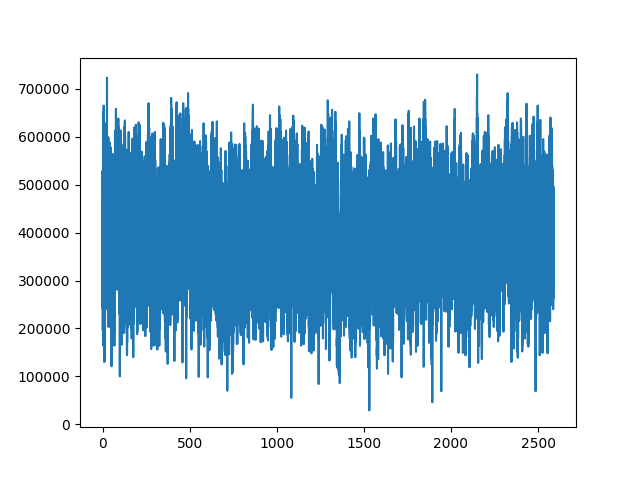

In [9]:
# Plot of the count rate through the scan
rate, secs = sp.loader.get_count_rate(range(100))
plt.plot(secs, rate)

In [10]:
# The time elapsed in the scan
sp.loader.get_elapsed_time()

2588.4949999999994

In [11]:
# Apply jittering to X, Y, t, ADC columns. 
# Columns are defined in the config, or can be provided as list.
sp.add_jitter()

In [12]:
# Inspect data in dataframe Columns:
# axes = ['X', 'Y', 't', 'ADC']
# bins = [100, 100, 100, 100]
# ranges = [(0, 1800), (0, 1800), (130000, 140000), (0, 9000)]
# sp.viewEventHistogram(dfpid=1, axes=axes, bins=bins, ranges=ranges)
sp.view_event_histogram(dfpid=2)

In [13]:
sp._dataframe

Dask DataFrame Structure:
                       X        Y        t      ADC
npartitions=100                                    
                 float64  float64  float64  float64
                     ...      ...      ...      ...
...                  ...      ...      ...      ...
                     ...      ...      ...      ...
                     ...      ...      ...      ...
Dask Name: apply_jitter, 600 tasks

# Distortion correction and Momentum Calibration workflow
### 1. step: 
Bin and load part of the dataframe in detector coordinates, and choose energy plane where high-symmetry points can well be identified. Either use the interactive tool, or pre-select the range:

100%|██████████| 7/7 [01:05<00:00,  9.41s/it]


interactive(children=(IntSlider(value=33, description='plane', max=290), IntSlider(value=10, description='widt…

Button(description='apply', style=ButtonStyle())

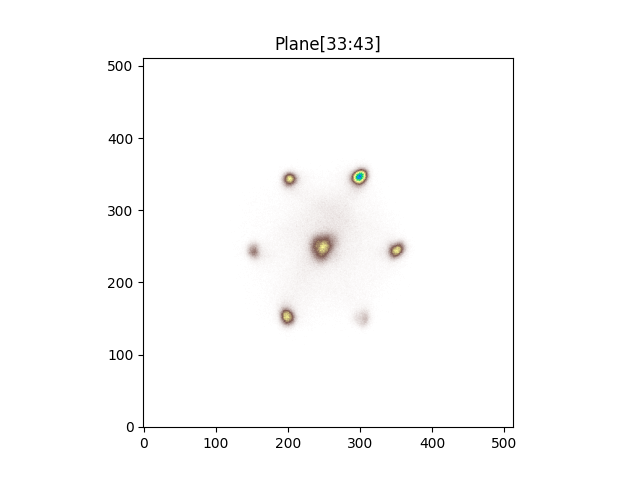

In [14]:
#sp.bin_and_load_momentum_calibration(df_partitions=20, plane=170)
sp.bin_and_load_momentum_calibration(df_partitions=100, rot_sym=6, plane=33, width=10, apply=True)

### 2. Step:
Next, we select a number of features corresponding to the rotational symmetry of the material, plus the center. These can either be auto-detected (for well-isolated points), or provided as a list (these can be read-off the graph in the cell above).
These are then symmetrized according to the rotational symmetry, and a spline-warping correction for the x/y coordinates is calculated, which corrects for any geometric distortions from the perfect n-fold rotational symmetry.

In [15]:
#features = np.array([[203.2, 341.96], [299.16, 345.32], [350.25, 243.70], [304.38, 149.88], [199.52, 152.48], [154.28, 242.27], [248.29, 248.62]])
#sp.generate_splinewarp(features=features, include_center=True)
# Autodetect: Uses the DAOStarFinder routine to locate maxima. 
# Parameters are: 
#   fwhm: Full-width at half maximum of peaks.
#   sigma: Number of standard deviations above the mean value of the image peaks must have.
#   sigma_radius: number of standard deviations around a peak that peaks are fitted
sp.generate_splinewarp(auto_detect=True, include_center=True, fwhm=10, sigma=12, sigma_radius=4)

Original slice with reference features


Corrected slice with target features


Original slice with target features


### 3rd Step:
To adjust scaling, position and orientation of the corrected momentum space image, you can apply further affine transformations to the distortion correction field. Here, first a postential scaling is applied, next a translation, and finally a rotation around the center of the image (defined via the config). One can either use an interactive tool, or provide the adjusted values and apply them directly.

interactive(children=(FloatSlider(value=1.0, description='scale', max=1.2, min=0.8, step=0.01), FloatSlider(va…

Button(description='apply', style=ButtonStyle())

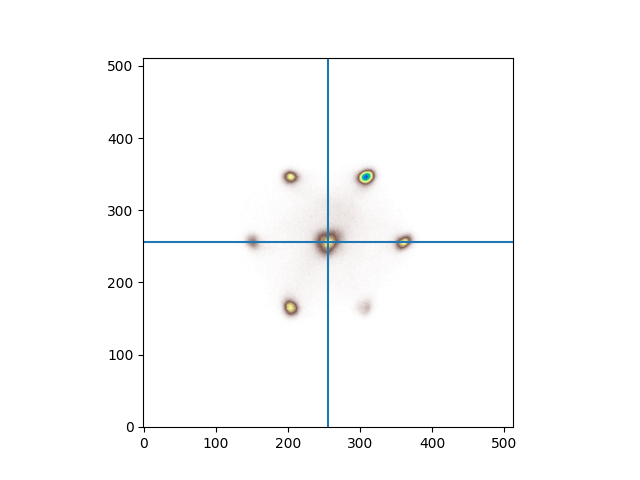

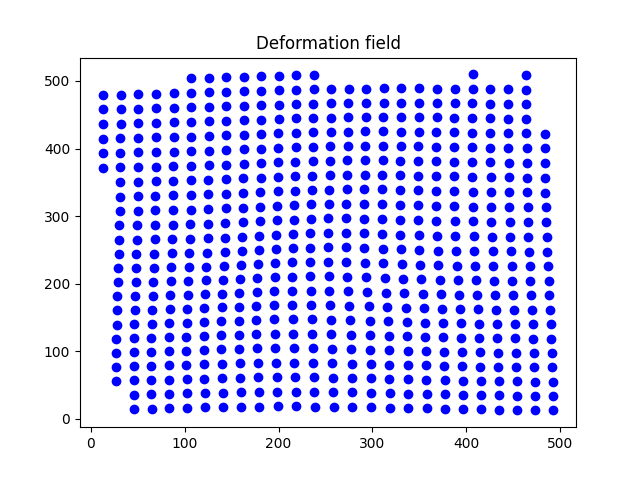

In [16]:
#sp.pose_adjustment(xtrans=14, ytrans=18, angle=2)
sp.pose_adjustment(xtrans=8, ytrans=7, angle=-4, apply=True)

### 4. Step:
Finally, the momentum correction is applied to the dataframe, and corresponding meta data are stored

In [17]:
sp._preprocessing_pipeline = []

In [18]:
sp.add_pre_processing(sp.mc.apply_corrections)

In [19]:
sp.pre_process()

Dask DataFrame Structure:
                       X        Y        t      ADC
npartitions=100                                    
                 float64  float64  float64  float64
                     ...      ...      ...      ...
...                  ...      ...      ...      ...
                     ...      ...      ...      ...
                     ...      ...      ...      ...
Dask Name: apply_corrections, 700 tasks

In [20]:
raise Exception("Stop here")

Exception: Stop here

## Momentum calibration workflow
### 1. Step:
First, the momentum scaling needs to be calibtrated. Either, one can provide the coordinates of one point outside the center, and provide its distane to the Brillouin zone center (which is assumed to be located in the center of the image), one can specify two points on the image and their distance (where the 2nd point marks the BZ center),or one can provide absolute k-coordinates of two distinct momentum points.

If no points are provided, an interactive tool is created. Here, left mouse click selectes the off-center point (brillouin_zone_cetnered=True) or toggle-selects the off-center and center point.

interactive(children=(IntText(value=308, description='point_a_x'), IntText(value=345, description='point_a_y')…

Button(description='apply', style=ButtonStyle())

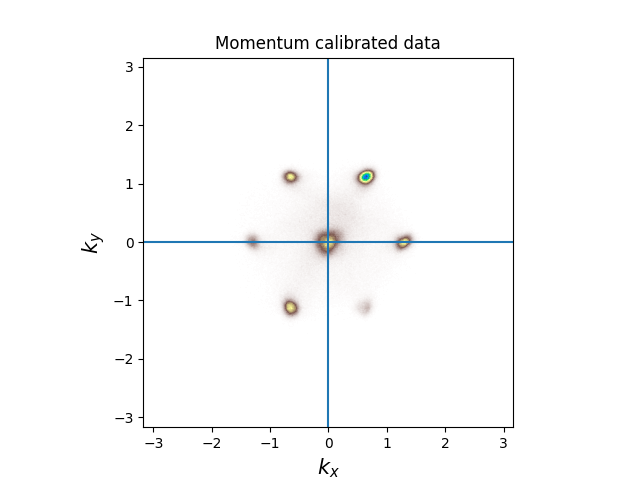

In [21]:
k_distance = 4/3*np.pi/3.28
#sp.calibrate_momentum_axes(k_distance = k_distance)
point_a = [308, 345]
sp.calibrate_momentum_axes(point_a=point_a, k_distance = k_distance, apply=True)
#point_b = [247, 249]
#sp.calibrate_momentum_axes(point_a=point_a, point_b = point_b, k_coord_a = [.5, 1.1], k_coord_b = [1.3, 0], equiscale=False

### 2. Step:
Now, the distortion correction and momentum calibration needs to be applied to the dataframe.

In [22]:
# sp.apply_momentum_calibration()
# sp.reset_pre_processing()
sp._preprocessing_pipeline = []
sp.add_pre_processing(sp.mc.append_k_axis)


In [23]:
sp._attributes

{'jittering': ['X', 'Y', 't', 'ADC'], 'apply_corrections': {'func': <bound method MomentumCorrector.apply_corrections of <sed.calibrator.momentum.MomentumCorrector object at 0x000001540F160F70>>, 'args': (), 'kwargs': {}}}

In [24]:
sp.pre_process()

Calculating inverse deformation field, this might take a moment...


AttributeError: 'DataFrame' object has no attribute 'map_partitions'

# Energy Correction (optional)
The purpose of the energy correction is to correct for any momentum-dependent distortion of the energy axis, e.g. from geometric effects in the flight tube, or from space charge

### 1st step:
Here, one can select the functional form to be used, and adjust its parameters. The binned data used for the momentum calibration is plotted around the Fermi energy (defined by tof_fermi), and the correction function is plotted ontop. Possible correction functions are: "sperical" (parameter: diameter), "Lorentzian" (parameter: gamma), "Gaussian" (parameter: sigma), and "Lorentzian_asymmetric" (parameters: gamma, amplitude2, gamma2).

One can either use an interactive alignment tool, or provide parameters directly.

In [ ]:
#sp.adjust_energy_correction(amplitude=2.5, center=(730, 730), gamma=920, tof_fermi = 66200)
sp.adjust_energy_correction(amplitude=2.5, center=(730, 730), gamma=920, tof_fermi = 66200, apply=True)

### 2. Step
After adjustment, the energy correction is directly applied to the TOF axis.

In [ ]:
sp.apply_energy_correction()

# 3. Energy calibration
For calibrating the energy axis, a set of data taken at different bias voltages around the value where the measurement was taken is required.

### 1. Step:
In a first step, the data are loaded, binned along the TOF dimension, and normalized. The used bias voltages can be either provided, or read from attributes in the source files if present.

In [ ]:
# Load energy calibration EDCs
energycalfolder = data_path + "energycal_2019_01_08/"
scans = np.arange(1,12)
voltages = np.arange(12,23,1)
files = [energycalfolder + r'Scan' + str(num).zfill(3) + '_' + str(num+11) + '.h5' for num in scans]
sp.load_bias_series(files, normalize=True, biases=voltages, ranges=[(64000, 75000)])

### 2. Step:
Next, the same peak or feature needs to be selected in each curve. For this, one needs to define "ranges" for each curve, within which the peak of interest is located. One can either provide these ranges manually, or provide one range for a "reference" curve, and infer the ranges for the other curves using a dynamic time warping algorithm.

In [ ]:
# Option 1 = specify the ranges containing a common feature (e.g an equivalent peak) for all bias scans
# rg = [(129031.03103103103, 129621.62162162163), (129541.54154154155, 130142.14214214214), (130062.06206206206, 130662.66266266267), (130612.61261261262, 131213.21321321322), (131203.20320320321, 131803.8038038038), (131793.7937937938, 132384.38438438438), (132434.43443443443, 133045.04504504506), (133105.10510510512, 133715.71571571572), (133805.8058058058, 134436.43643643643), (134546.54654654654, 135197.1971971972)]
# Option 2 = specify the range for one curve and infer the others
# IMPORTANT: Don't choose the range too narrow about a peak, and choose a refid 
# somewhere in the middle or towards larger biases!
rg = (66100, 67000)
sp.find_bias_peaks(ranges=rg, ref_id=5, infer_others=True)

### 3. Step:
Next, the detected peak positions and bias voltages are used to determine the calibration function. This can be either done by fitting the functional form d^2/(t-t0)^2 via lmfit ("lmfit"), or using a polynomial approxiamtion ("lstsq" or "lsqr"). Here, one can also define a reference id, and a reference energy. Those define the absolute energy position of the feature used for calibration in the "reference" trace, at the bias voltage where the final measurement has been performed. The energy scale can be either "kientic" (decreasing energy with increasing TOF), or "binding" (increasing energy with increasing TOF).

After calculating the calibration, all traces corrected with the calibration are plotted ontop of each other, the calibration function together with the extracted features is plotted.

In [ ]:
# use the refid of the bias that the measurement was taken at
# Eref can be used to set the absolute energy (kinetic energy, E-EF) of the feature used for energy calibration (if known)
refid=4
Eref=-0.5
# the lmfit method uses a fit of (d/(t-t0))**2 to determine the energy calibration
sp.calibrate_energy_axis(ref_energy=Eref, ref_id=refid, energy_scale="kinetic", method="lmfit")

### 4. Step:
Finally, the the energy axis is added to the dataframe.

In [ ]:
sp.append_energy_axis()

# 4. Delay calibration:
The delay axis is calculated from the ADC input column based on the provided delay range. ALternatively, the delay scan range can also be extracted from attributes inside a source file, if present.

In [ ]:
#from pathlib import Path
#datafile = "file.h5"
#print(datafile)
#sp.calibrate_delay_axis(datafile=datafile)
delay_range = (-500, 1500)
sp.calibrate_delay_axis(delay_range=delay_range, preview=True)

# 5. Visualization of calibrated histograms
With all calibrated axes present in the dataframe, we can visualize the corresponding histograms, and determine the respective binning ranges

In [ ]:
axes = ['kx', 'ky', 'energy', 'delay']
ranges = [[-3, 3], [-3, 3], [-6, 2], [-600, 1600]]
sp.view_event_histogram(dfpid=1, axes=axes, ranges=ranges)

# Define the binning ranges and compute calibrated data volume

In [ ]:
axes = ['kx', 'ky', 'energy', 'delay']
bins = [100, 100, 200, 50]
ranges = [[-2, 2], [-2, 2], [-4, 2], [-600, 1600]]
res = sp.compute(bins=bins, axes=axes, ranges=ranges)

# Some visualization:

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(6, 18), constrained_layout=True)
res.loc[{'energy':slice(-.1, 0)}].sum(axis=(2,3)).T.plot(ax=axs[0])
res.loc[{'kx':slice(-.8, -.5)}].sum(axis=(0,3)).T.plot(ax=axs[1])
res.loc[{'ky':slice(-.2, .2)}].sum(axis=(1,3)).T.plot(ax=axs[2])
res.loc[{'kx':slice(-.8, -.5), 'energy':slice(.5, 2)}].sum(axis=(0,1)).plot(ax=axs[3])